In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html

### Adjacency Matricies

In [2]:
def random_connectivity_matrix(n, med_frac = 1.0, source_rate = 0.1, all_source_connections = 0, random_state = 10):
    rng = np.random.RandomState(random_state) # fixed random state
    
    A = rng.rand(n, n)
    A = np.dot(A.T, A)
    np.fill_diagonal(A, 0)
    K = A.copy()

    for i in range(n):
        loc_thresh = min(med_frac * np.median(A[i, 1:]), max(A[i, 1:] * 0.99))
        ind = A[i, 1:] < loc_thresh
        ind = np.insert(ind, 0, False)
        K[i, ind] = 0
        K[ind, i] = 0

    S = np.sum(K > 0.0, axis=0)
    for i in range(n):
        if S[i] == 0 or (i == 1 and S[i] < 2):
            if i != 1:
                val, ind = max((val, idx) for idx, val in enumerate(A[i, 1:]))
                K[i, ind + 1] = val
                K[ind + 1, i] = val
            else:
                val, ind = max((val, idx) for idx, val in enumerate(A[i, 2:]))
                K[i, ind + 2] = val
                K[ind + 2, i] = val

    K /= np.max(K)
    if all_source_connections:
        K[0, :] = source_rate
        K[:, 0] = source_rate
    else:
        K[0, :] = 0.0
        K[:, 0] = 0.0

    K[0, 1] = source_rate
    K[1, 0] = source_rate

    return K

def random_zero_diagonal_matrix(size, random_state = 10):
    """Generates an adjacency matrix with zero diagonal."""
    rng = np.random.RandomState(random_state) # fixed random state
    A = rng.rand(size, size)
    np.fill_diagonal(A, 0)
    return A

def binary_zero_diagonal_matrix(size):
    """Generates an adjacency matrix with zero diagonal."""
    A = np.ones([size, size])
    np.fill_diagonal(A, 0)
    return A

def tridiagonal_matrix(size):
    """Generates a binary tridiagonal adjacency matrix with zero diagonal."""
    A = np.zeros((size, size))
    np.fill_diagonal(A[:-1, 1:], 1)
    np.fill_diagonal(A[1:, :-1], 1)
    return A

def compute_laplacian_matrix(A):
    """Generates the Laplacian matrix from the adjacency matrix as described by Garbarino."""
    degree_matrix = np.diag(np.sum(A, axis=1))
    laplacian_matrix = degree_matrix - A
    return laplacian_matrix

In [3]:
size = 3

A_random = random_connectivity_matrix(size)
print(f"random_connectivity_matrix:\n{A_random}")

A_random_zero_diag = random_zero_diagonal_matrix(size)
print(f"\nrandom_zero_diagonal_matrix:\n{A_random_zero_diag}")

A_binary_zero = binary_zero_diagonal_matrix(size)
print(f"\nbinary_zero_diagonal_matrix:\n{A_binary_zero}")

A_tridiagonal = tridiagonal_matrix(size)
print(f"\ntridiagonal_matrix:\n{A_tridiagonal}")

random_connectivity_matrix:
[[0.         0.1        0.        ]
 [0.1        0.         0.36756077]
 [0.         0.36756077 0.        ]]

random_zero_diagonal_matrix:
[[0.         0.02075195 0.63364823]
 [0.74880388 0.         0.22479665]
 [0.19806286 0.76053071 0.        ]]

binary_zero_diagonal_matrix:
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]

tridiagonal_matrix:
[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]


### Compute Laplacian

In [4]:
def compute_laplacian_matrix(A):
    """Generates the Laplacian matrix from the adjacency matrix as described by Garbarino."""
    degree_matrix = np.diag(np.sum(A, axis=1))
    laplacian_matrix = degree_matrix - A
    return laplacian_matrix

L_random = compute_laplacian_matrix(A_random)
print(f"random_connectivity_matrix:\n{L_random}")

L_random_zero_diag = compute_laplacian_matrix(A_random_zero_diag)
print(f"\nrandom_zero_diagonal_matrix:\n{L_random_zero_diag}")

L_binary_zero = compute_laplacian_matrix(A_binary_zero)
print(f"\nbinary_zero_diagonal_matrix:\n{L_binary_zero}")

L_tridiagonal = compute_laplacian_matrix(A_tridiagonal)
print(f"\ntridiagonal_matrix:\n{L_tridiagonal}")

random_connectivity_matrix:
[[ 0.1        -0.1         0.        ]
 [-0.1         0.46756077 -0.36756077]
 [ 0.         -0.36756077  0.36756077]]

random_zero_diagonal_matrix:
[[ 0.65440018 -0.02075195 -0.63364823]
 [-0.74880388  0.97360053 -0.22479665]
 [-0.19806286 -0.76053071  0.95859358]]

binary_zero_diagonal_matrix:
[[ 2. -1. -1.]
 [-1.  2. -1.]
 [-1. -1.  2.]]

tridiagonal_matrix:
[[ 1. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  1.]]


### ACP Model
 
$$
f(\tau) = \left( A \odot K_{\theta_{ACP}}(f, \tau) \right) Hf(\tau) + R_{\theta_{ACP}}(f, \tau)f(\tau)
$$

Where:
This equation describes the evolution of protein concentration $ f(\tau) $ in each brain region (biomarker) over time, considering both propagation between regions and aggregation within regions.

**$A$**: Adjacency matrix, the brain's connectivity network.
**$H$**: Laplacian matrix computed from the adjacency matrix.
**$K_{\theta_{ACP}}(f, \tau) $**: Concentration-dependent propagation term, which is a function of protein concentration $ f(\tau) $ and thresholds $ \gamma $ and $ \eta $.
**$ R_{\theta_{ACP}}(f, \tau) $**: Aggregation term, which also depends on the concentration $ f(\tau) $ and the threshold $ \eta $.

1. **$ K_{\theta_{ACP}}(f(\tau), \gamma, \eta) $: Concentration-Dependent Propagation Term**

   $$
   K_{\theta_{ACP}}(f_j(\tau), \gamma_j, \eta_j) = k_{ij} \times \frac{1}{(1 + e^{-l_1(f_j(\tau) - \gamma_j)})(1 + e^{l_2(f_j(\tau) - \eta_j)})}
   $$

   This describes the propagation term, where $ k_{ij} $ is the constant propagation rate between regions, $ f_j(\tau) $ is the concentration of protein in region $ j $ at time $ \tau $, and $ \gamma_j $, $ \eta_j $ are the thresholds for propagation. The parameters $ l_1 $ and $ l_2 $ control the shape of the sigmoid functions.

2. **$ R_{\theta_{ACP}}(f(\tau), \eta) $: Aggregation Term**

   $$
   R_{\theta_{ACP}}(f_i(\tau), \eta_i) = 
   \begin{cases} 
   \frac{k_t}{1 + e^{l_2(f_i(\tau) - \eta_i)}} & \text{if } i = j \\
   0 & \text{otherwise}
   \end{cases}
   $$

   This describes the aggregation term, where $ k_t $ is the constant rate of aggregation, $ f_i(\tau) $ is the concentration of protein in region $ i $ at time $ \tau $, and $ \eta_i $ is the threshold for aggregation. This function assumes that aggregation only occurs within the same region (i.e., when $ i = j $).

In [5]:
def get_adjacency_matrix(matrix_type, size):
    """Return the selected adjacency matrix based on the matrix_type."""
    if matrix_type == "Random Zero Diagonal":
        return random_zero_diagonal_matrix(size)
    elif matrix_type == "Binary Zero Diagonal":
        return binary_zero_diagonal_matrix(size)
    elif matrix_type == "Tridiagonal":
        return tridiagonal_matrix(size)
    else:
        return tridiagonal_matrix(size)

def acp_model(A, H, l1_mean, l2_mean, gamma_mean, eta_mean, k_ij_value, random_state=10):
    np.random.seed(random_state)
    n = A.shape[0]
    t = np.linspace(0, 20, 1000)
    dt = t[1] - t[0]  # time step
    x0 = np.zeros(n)
    x0[0] = 0.05

    # params
    l1 = np.random.normal(loc=l1_mean, scale=1, size=n)
    l2 = np.random.normal(loc=l2_mean, scale=1, size=n)
    gamma = np.random.normal(loc=gamma_mean, scale=0.1, size=n)
    eta = np.random.normal(loc=eta_mean, scale=0.1, size=n)
    k_ij = np.random.normal(loc=k_ij_value, scale=0.1, size=n)

    def acp_equations(f, tau, A, H, k_ij, gamma, eta, l1, l2):
        exp_1 = -l1 * (f - gamma)
        exp_2 = l2 * (f - eta)

        K_ACP = k_ij / ((1 + np.exp(exp_1)) * (1 + np.exp(exp_2)))
        R_ACP = k_ij / (1 + np.exp(exp_2))
        dfdtau = np.dot((A * K_ACP), np.dot(H, f)) + np.multiply(R_ACP, f)
        return dfdtau

    # solution array
    x = np.zeros((n, len(t)))
    x[:, 0] = x0

    # forward euler method
    for i in range(1, len(t)):
        dx_dt = acp_equations(x[:, i-1], t[i-1], A, H, k_ij, gamma, eta, l1, l2)
        x[:, i] = x[:, i-1] + dx_dt * dt
        x[:, i] = np.maximum(x[:, i], 0)  # enforce non-negativity

    return t, x

In [6]:
def plot_acp_interactive(l1_mean, l2_mean, gamma_mean, eta_mean, k_ij_value, matrix_type):
    size = 3
    A = get_adjacency_matrix(matrix_type, size)
    H = compute_laplacian_matrix(A)
    
    t, x = acp_model(A, H, l1_mean, l2_mean, gamma_mean, eta_mean, k_ij_value, random_state=10)
    
    plt.figure(figsize=(6, 6))
    for i in range(size):
        plt.plot(t, x[i], label=f'Biomarker {i+1}')
    
    plt.title(f"ACP Model with l1={l1_mean:.2f}, l2={l2_mean:.2f}, gamma={gamma_mean:.2f}, eta={eta_mean:.2f}, k_ij={k_ij_value:.2f}\nMatrix: {matrix_type}")
    plt.xlabel('Time')
    plt.ylabel('Biomarker Value')
    plt.legend()
    plt.show()

# interact containter for widgets. Target function --> params
interact(plot_acp_interactive,
         l1_mean=widgets.FloatSlider(value=3.0, min=0.5, max=5.0, step=0.5),    # from paper, default = 3,   but when varied goes from 0.5 --> 3 --> 5 
         l2_mean=widgets.FloatSlider(value=3.0, min=0.5, max=5.0, step=0.5),    # from paper, default = 3,   but when varied goes from 0.5 --> 3 --> 5
         gamma_mean=widgets.FloatSlider(value=0.6, min=0.1, max=2.0, step=0.1), # from paper, default = 0.6, but when varied goes from 0.1 --> 0.6 --> 2
         eta_mean=widgets.FloatSlider(value=0.9, min=0.3, max=3.0, step=0.1),   # from paper, default = 0.9, but when varied goes from 0.3 --> 0.9 --> 3
         k_ij_value=widgets.FloatSlider(value=0.5, min=0.05, max=1.0, step=0.05), # varying kij as per paper
         matrix_type=widgets.Dropdown(options=["Random Zero Diagonal", "Binary Zero Diagonal", "Tridiagonal"], value="Tridiagonal"))

interactive(children=(FloatSlider(value=3.0, description='l1_mean', max=5.0, min=0.5, step=0.5), FloatSlider(v…

<function __main__.plot_acp_interactive(l1_mean, l2_mean, gamma_mean, eta_mean, k_ij_value, matrix_type)>

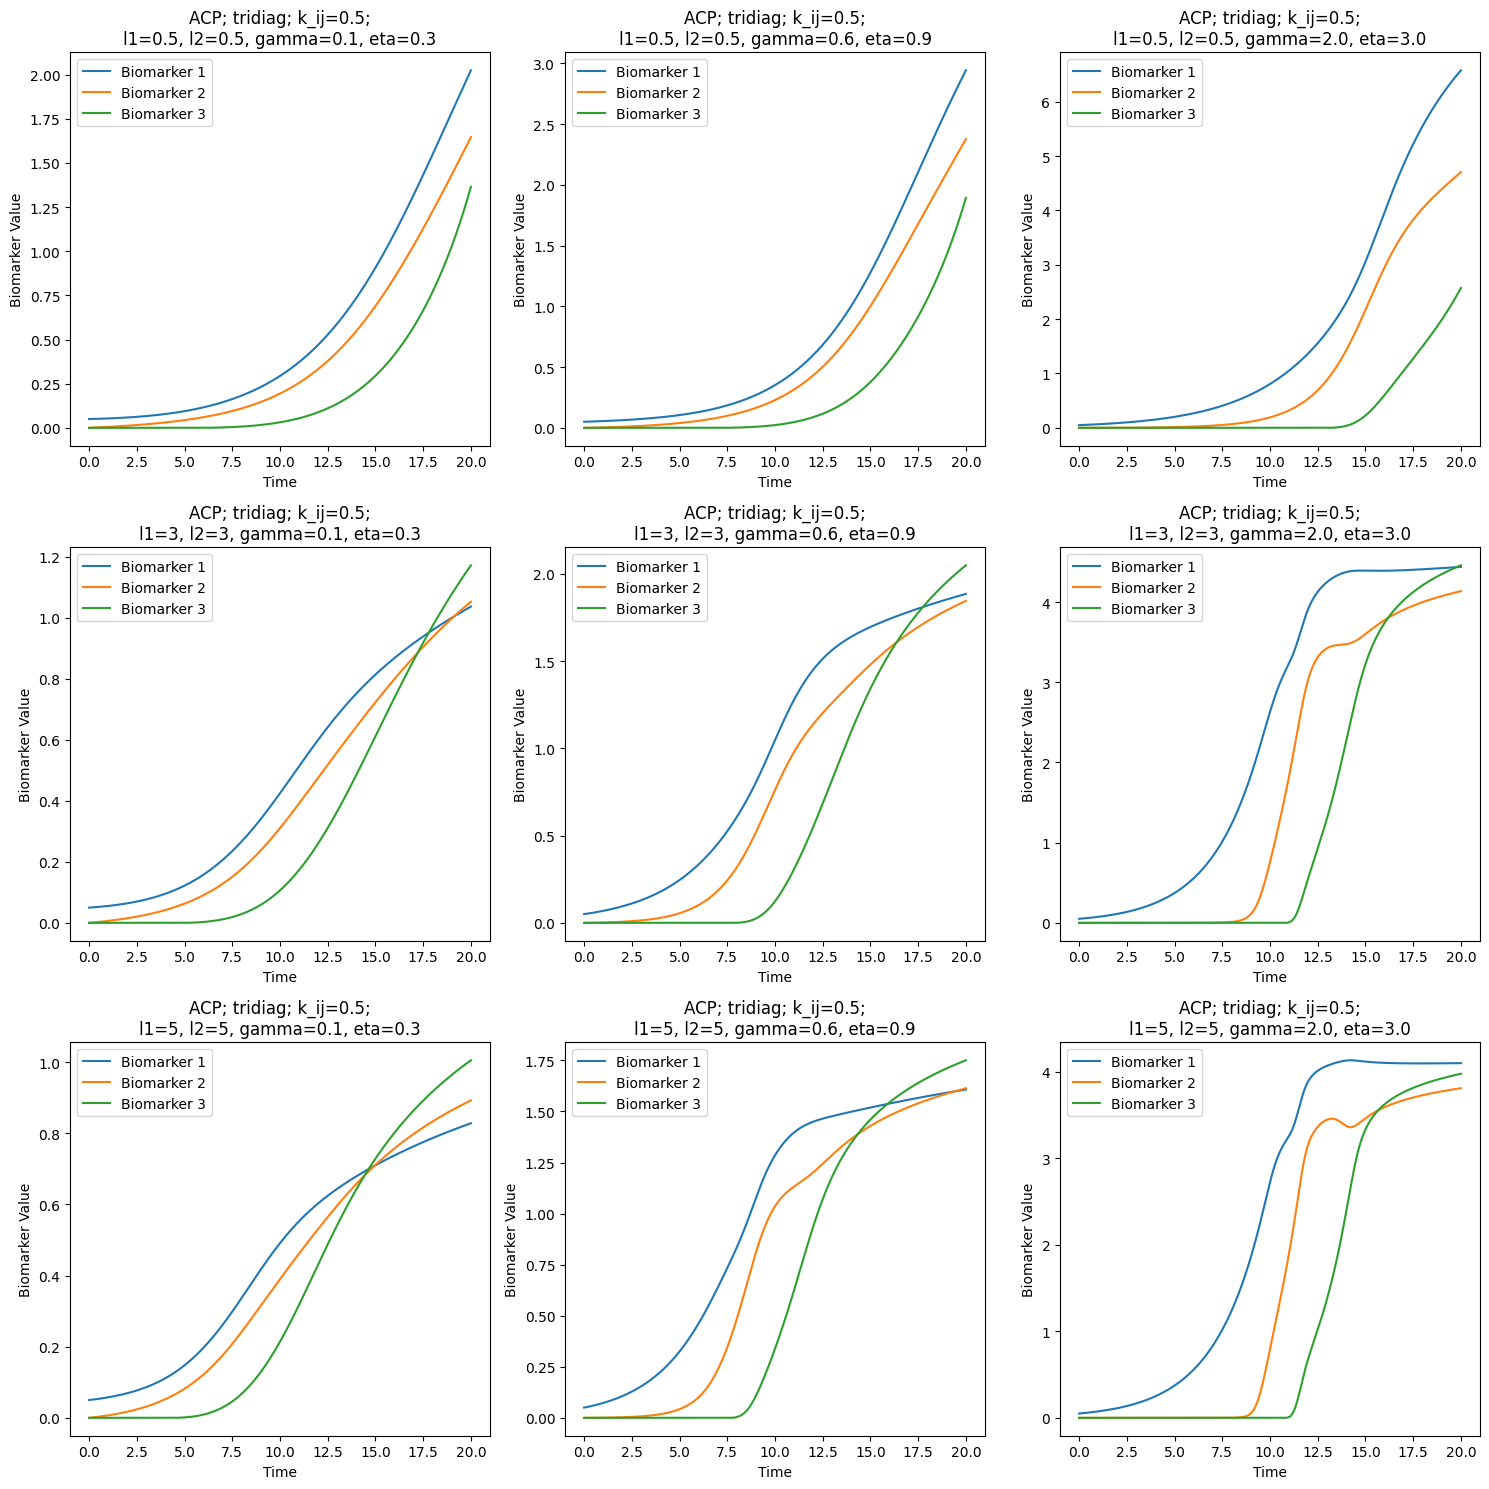

In [7]:
# 3x3 subplots with fixed k_ij_value = 0.5
def plot_acp_subplot():
    size = 3
    matrix_types = ["Random Zero Diagonal", "Binary Zero Diagonal", "Tridiagonal"]
    
    parameter_sets = [
        {'l1_mean': 0.5, 'l2_mean': 0.5, 'gamma_mean': 0.1, 'eta_mean': 0.3},
        {'l1_mean': 0.5, 'l2_mean': 0.5, 'gamma_mean': 0.6, 'eta_mean': 0.9},
        {'l1_mean': 0.5, 'l2_mean': 0.5, 'gamma_mean': 2.0, 'eta_mean': 3.0},
        {'l1_mean': 3, 'l2_mean': 3, 'gamma_mean': 0.1, 'eta_mean': 0.3},
        {'l1_mean': 3, 'l2_mean': 3, 'gamma_mean': 0.6, 'eta_mean': 0.9},
        {'l1_mean': 3, 'l2_mean': 3, 'gamma_mean': 2.0, 'eta_mean': 3.0},
        {'l1_mean': 5, 'l2_mean': 5, 'gamma_mean': 0.1, 'eta_mean': 0.3},
        {'l1_mean': 5, 'l2_mean': 5, 'gamma_mean': 0.6, 'eta_mean': 0.9},
        {'l1_mean': 5, 'l2_mean': 5, 'gamma_mean': 2.0, 'eta_mean': 3.0},
    ]

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()  # flatten the axes for better indexing

    for idx, params in enumerate(parameter_sets):
        A = get_adjacency_matrix("Tridiagonal", size)  # <-- change connectivity matrix here
        H = compute_laplacian_matrix(A)
        
        k_ij_value = 0.5  # fixed in this instance
        t, x = acp_model(A, H, params['l1_mean'], params['l2_mean'], params['gamma_mean'], params['eta_mean'], k_ij_value, random_state=10)
        
        ax = axes[idx]
        for i in range(size):
            ax.plot(t, x[i], label=f'Biomarker {i+1}')
        
        title = (f"ACP; tridiag; k_ij=0.5;\n"
                 f"l1={params['l1_mean']}, l2={params['l2_mean']}, "
                 f"gamma={params['gamma_mean']}, eta={params['eta_mean']}")
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Biomarker Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_acp_subplot()